# Проект для «Викишоп» c BERT (и без BERT)

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score 
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve 
from sklearn.metrics import precision_recall_curve

import torch
import transformers
from tqdm import notebook

from pymystem3 import Mystem
import re
import spacy

import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer 
from nltk.corpus import stopwords as nltk_stopwords

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\e.yumagulov\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\e.yumagulov\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\e.yumagulov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
# Константы
RS = 12345 # random state
TS = .25 # test size
FR_DOWNSAMPLE = 0.1 # fraction downsample
FR_DOWNSAMPLE_CLASS = 0.1 # fraction downsample for class
MAX_WORDS = 100 # maximum words in sentences
CRIT_F1 = .75
MXL = 512 # max lenght BERT

In [5]:
df_comm = pd.read_csv(r'c:\Users\e.yumagulov\datasets\toxic_comments.csv')
df_comm.info()
display(df_comm.head())
display(df_comm.query('toxic==1').head()) # А что насчет токсичных комментов?
display(df_comm.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


,text,toxic
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
12,Hey... what is it..\n@ | talk .\nWhat is it......,1
16,"Bye! \n\nDon't look, come or think of comming ...",1
42,You are gay or antisemmitian? \n\nArchangel WH...,1
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1


,toxic
count,159571.000000
mean,0.101679
std,0.302226
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [6]:
df_comm['len'] = df_comm['text'].apply(len)
print('Размер комментариев (в символах):', df_comm['len'].min(),'-',df_comm['len'].max())
df_comm = df_comm.drop('len', axis=1)
cnt = df_comm[df_comm['toxic']==1]['toxic'].count()
all = df_comm.shape[0]
print(f'Количество токсичных комментариев {cnt} из общего числа {all} ({np.round(100 * cnt / all, 2)}%)')

Размер комментариев (в символах): 6 - 5000
Количество токсичных комментариев 16225 из общего числа 159571 (10.17%)


In [7]:
# Надо сбалансировать классы - т.к. мы предсказываем токсичность, то уменьшим количество нетоксичных комментов в выборке

def downsample(df_in, ftr, trg, fraction):
    features_zeros = df_in[df_in[trg] == 0][ftr]
    features_ones = df_in[df_in[trg] == 1][ftr]
    target_zeros = df_in[df_in[trg] == 0][trg]
    target_ones = df_in[df_in[trg] == 1][trg]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=RS)] + [features_ones]) 
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=RS)] + [target_ones]) 
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=RS)
    
    df_out = pd.DataFrame()
    df_out[ftr] = features_downsampled
    df_out[trg] = target_downsampled
    return df_out

In [8]:
# Удаляем нетоксичные комментарии
print('Размер выборки ДО:', df_comm.shape)

df_comm = downsample(df_in=df_comm, ftr='text', trg='toxic', fraction=FR_DOWNSAMPLE_CLASS)

print('Размер выборки ПОСЛЕ:',df_comm.shape)

Размер выборки ДО: (159571, 2)
Размер выборки ПОСЛЕ: (30560, 2)


In [9]:
print(f'Мы удалили {round(FR_DOWNSAMPLE_CLASS*100)}% нетоксичных комментариев. Проверяем что получилось:')
cnt = df_comm[df_comm['toxic']==1]['toxic'].count()
all = df_comm.shape[0]
prc = np.round(100 * cnt / all, 0)
print(f'Количество токсичных комментариев {cnt} из общего числа {all} ({prc}%)')
ppp = int(np.round(prc / 10, 0))
if ppp == 5:
    print('Выборка сбалансирована!')

Мы удалили 10% нетоксичных комментариев. Проверяем что получилось:
Количество токсичных комментариев 16225 из общего числа 30560 (53.0%)
Выборка сбалансирована!


In [10]:
# Сначала потренируемся на малом объеме данных
print(f'Для исследования берем {round(FR_DOWNSAMPLE*100)}% от сбалансированной выборки.')
df_comm = df_comm.sample(frac=FR_DOWNSAMPLE, random_state=RS).reset_index(drop=True)
df_comm.info()

Для исследования берем 10% от сбалансированной выборки.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3056 entries, 0 to 3055
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3056 non-null   object
 1   toxic   3056 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.9+ KB


In [11]:
print('Проверим как изменился % токсичных комментарив после уменьшения выборки:')
cnt = df_comm[df_comm['toxic']==1]['toxic'].count()
all = df_comm.shape[0]
print(f'Количество токсичных комментариев {cnt} из общего числа {all} ({np.round(100 * cnt / all, 2)}%)')
ppp = int(np.round(prc / 10, 0))
if ppp == 5:
    print('Выборка сбалансирована!')

Проверим как изменился % токсичных комментарив после уменьшения выборки:
Количество токсичных комментариев 1624 из общего числа 3056 (53.14%)
Выборка сбалансирована!


### Вариант с BERT

In [40]:
%time

#tokenizer = transformers.BertTokenizer(vocab_file='/datasets/ds_bert/vocab.txt')
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

tokenized = df_comm['text'].apply(lambda x: tokenizer.encode(x, truncation=True, max_length=MXL, add_special_tokens=True))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values]) 
attention_mask = np.where(padded != 0, 1, 0)
#config = transformers.BertConfig.from_json_file('/datasets/ds_bert/bert_config.json')
#model = transformers.BertModel.from_pretrained('/datasets/ds_bert/rubert_model.bin', config=config)
model = transformers.DistilBertModel.from_pretrained("distilbert-base-uncased")

Wall time: 0 ns


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
print('Проверка доступности CUDA:', torch.cuda.is_available())
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print('Выбрано устройство:', device)

Проверка доступности CUDA: False
Выбрано устройство: cpu


In [48]:
%time

batch_size = 100
embeddings = []
#for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
#    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
#    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])



for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
#    embeddings.append(batch_embeddings[0][:,0,:].numpy())
    embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

Wall time: 0 ns


  0%|          | 0/30 [00:00<?, ?it/s]

In [49]:
%time

bert_features = np.concatenate(embeddings)
l1 = len(bert_features)
print('Размер выборки features:', l1)
bert_target = df_comm['toxic']
l2 = len(bert_target)
print('Размер выборки target:', l2)

if l1 < l2:
    print('Что-то пошло не так - куда-то подевалась часть признаков. Отбрасываем лишние таргеты.')
    bert_target = bert_target[:l1]
    print('Размер выборки target (cut):',len(bert_target))
elif l1 > l2:
    print('Что-то пошло не так - куда-то подевалась часть таргетов. Отбрасываем лишние признаки.')
    bert_features = bert_features[:l2]
    print('Размер выборки features target (cut):',len(bert_features))

print('Разделяем выборку на обучающую и тестовую:')
#bert_features_train, bert_features_test, bert_target_train, bert_target_test = train_test_split(bert_features, bert_target, stratify=bert_target, test_size=0.25, random_state=RS)
bert_features_train, bert_features_test, bert_target_train, bert_target_test = train_test_split(bert_features, bert_target, stratify=bert_target, test_size=0.25, random_state=RS)
print('-- размер обучающей выборки:', bert_features_train.shape[0], 'признаков и', len(bert_target_train), 'таргетов')
print('-- размер тестовой выборки:', bert_features_test.shape[0], 'признаков и', len(bert_target_test), 'таргетов')

Wall time: 0 ns
Размер выборки features: 3000
Размер выборки target: 3056
Что-то пошло не так - куда-то подевалась часть признаков. Отбрасываем лишние таргеты.
Размер выборки target (cut): 3000
Разделяем выборку на обучающую и тестовую:
-- размер обучающей выборки: 2250 признаков и 2250 таргетов
-- размер тестовой выборки: 750 признаков и 750 таргетов


### Вариант без BERT

In [50]:
m = Mystem()

def lemmatize_m(text):
    lemm_list = m.lemmatize(text)
    lemm_text = "".join(lemm_list)
    return lemm_text

ttt = "The striped bats are hanging on their feet for best"
print('Проверяем работу Mystem (с POS):')
print('Исходная фраза:', ttt)
print('Лемматизированная Mystem:', lemmatize_m(ttt))

def clear_text_eng(text):
    clear_text = re.sub(r'[^a-zA-Z\'\- ]', ' ', text) 
    clear_text = " ".join(clear_text.split())
    return clear_text

ttt = "@Joe1977 Don't be silly!!! Не тупи, Buy semi-conductor..."
print('Проверяем работу очистки текста:')
print('Исходная фраза:', ttt)
print('Очищенная фраза:', clear_text_eng(ttt))

Проверяем работу Mystem (с POS):
Исходная фраза: The striped bats are hanging on their feet for best
Лемматизированная Mystem: The striped bats are hanging on their feet for best

Проверяем работу очистки текста:
Исходная фраза: @Joe1977 Don't be silly!!! Не тупи, Buy semi-conductor...
Очищенная фраза: Joe Don't be silly Buy semi-conductor


### Вывод:
Mystem не подходит для лемматизации английских текстов.

In [51]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [54]:
nltk.download('punkt')
lemmatizer = WordNetLemmatizer()

def lemmatize_eng_nltk(sentence):
    word_list = nltk.word_tokenize(sentence)
# ограничиваем максимум анализируемых слов в комментарии      
    l = MAX_WORDS
    if len(word_list)<MAX_WORDS:
        l = len(word_list)
    word_list = word_list[:l] 
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_list])
#    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output

ttt = "The striped bats are hanging on their feet for best"
print('Проверяем работу nltk (с POS):')
print('Исходная фраза:', ttt)
print('Лемматизированная nltk (с POS):', lemmatize_eng_nltk(ttt))

Проверяем работу nltk (с POS):
Исходная фраза: The striped bats are hanging on their feet for best
Лемматизированная nltk (с POS): The strip bat be hang on their foot for best


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\e.yumagulov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [55]:
%time

print('Очищаем комментарии...')
df_comm['clear_text'] = df_comm['text'].apply(clear_text_eng)
display(df_comm.head())
print('Лемматизируем комментарии с nltk...')
df_comm['nltk_text'] = df_comm['clear_text'].apply(lemmatize_eng_nltk)
display(df_comm.head())

Wall time: 0 ns
Очищаем комментарии...


,text,toxic,clear_text,nltk_text
0,liar \n\nThis guy is such a thief and a liar! ...,1,liar This guy is such a thief and a liar He sh...,liar This guy be such a thief and a liar He sh...
1,"""\n\nOf course, of course, Pharos, I am famili...",0,Of course of course Pharos I am familiar with ...,Of course of course Pharos I be familiar with ...
2,My Thoughts \n\nYou're a jackass.\n\nDoes this...,1,My Thoughts You're a jackass Does this look fa...,My Thoughts You re a jackass Does this look fa...
3,. I should become a detective for figuring all...,1,I should become a detective for figuring all t...,I should become a detective for figure all tha...
4,GIMME GIMME \n\nI wanted all of you BASTARDS t...,1,GIMME GIMME I wanted all of you BASTARDS to kn...,GIM ME GIM ME I want all of you BASTARDS to kn...


Лемматизируем комментарии с nltk...


,text,toxic,clear_text,nltk_text
0,liar \n\nThis guy is such a thief and a liar! ...,1,liar This guy is such a thief and a liar He sh...,liar This guy be such a thief and a liar He sh...
1,"""\n\nOf course, of course, Pharos, I am famili...",0,Of course of course Pharos I am familiar with ...,Of course of course Pharos I be familiar with ...
2,My Thoughts \n\nYou're a jackass.\n\nDoes this...,1,My Thoughts You're a jackass Does this look fa...,My Thoughts You 're a jackass Does this look f...
3,. I should become a detective for figuring all...,1,I should become a detective for figuring all t...,I should become a detective for figure all tha...
4,GIMME GIMME \n\nI wanted all of you BASTARDS t...,1,GIMME GIMME I wanted all of you BASTARDS to kn...,GIM ME GIM ME I want all of you BASTARDS to kn...


In [56]:
%time

nlp = spacy.load("en_core_web_sm")

def lemmatize_eng_spacy(sentence):
    doc = nlp(sentence)
# ограничиваем максимум анализируемых слов в комментарии    
    l = MAX_WORDS
    if len(doc)<MAX_WORDS:
        l = len(doc)
    doc = doc[0:l]
    txt = " ".join([token.lemma_ for token in doc])
    return txt

print('Проверяем работу spacy:')
print('Исходная фраза:', ttt)
print('Лемматизированная spacy:', lemmatize_eng_spacy(ttt))

Wall time: 0 ns
Проверяем работу spacy:
Исходная фраза: The striped bats are hanging on their feet for best
Лемматизированная spacy: the stripe bat be hang on their foot for good


In [57]:
%time

print('Лемматизируем комментарии со spacy...')
df_comm['spacy_text'] = df_comm['clear_text'].apply(lemmatize_eng_spacy)
display(df_comm.head())

Wall time: 0 ns
Лемматизируем комментарии со spacy...


,text,toxic,clear_text,nltk_text,spacy_text
0,liar \n\nThis guy is such a thief and a liar! ...,1,liar This guy is such a thief and a liar He sh...,liar This guy be such a thief and a liar He sh...,liar this guy be such a thief and a liar he sh...
1,"""\n\nOf course, of course, Pharos, I am famili...",0,Of course of course Pharos I am familiar with ...,Of course of course Pharos I be familiar with ...,of course of course Pharos I be familiar with ...
2,My Thoughts \n\nYou're a jackass.\n\nDoes this...,1,My Thoughts You're a jackass Does this look fa...,My Thoughts You 're a jackass Does this look f...,my Thoughts you be a jackass do this look fami...
3,. I should become a detective for figuring all...,1,I should become a detective for figuring all t...,I should become a detective for figure all tha...,I should become a detective for figure all tha...
4,GIMME GIMME \n\nI wanted all of you BASTARDS t...,1,GIMME GIMME I wanted all of you BASTARDS to kn...,GIM ME GIM ME I want all of you BASTARDS to kn...,GIMME GIMME I want all of you BASTARDS to know...


In [58]:
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords) 

### Cначала детально пройдемся по spacy

In [59]:
# сначала детально пройдемся по spacy
#spacy_text = df_comm['spacy_text'].values.astype('U')
spacy_text = df_comm['spacy_text']
target = df_comm['toxic']
, 
#spacy_text_train, spacy_text_test, target_spacy_train, target_spacy_test = train_test_split(spacy_text, target, test_size=TS, random_state=RS)
spacy_text_train, spacy_text_test, target_spacy_train, target_spacy_test = train_test_split(spacy_text,
                                                                                            target,
                                                                                            stratify=target,
                                                                                            test_size=TS,
                                                                                            random_state=RS
                                                                                           )

In [60]:
%time

features_spacy_train = count_tf_idf.fit_transform(spacy_text_train) 
features_spacy_test = count_tf_idf.transform(spacy_text_test) 

Wall time: 0 ns


In [61]:
%time

#solver{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
#class_weight='balanced'
model_spacy = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=100, class_weight=None, random_state=RS, C=10) #т.к. классы несбалансированы
model_spacy.fit(features_spacy_train, target_spacy_train)

pred_spacy = model_spacy.predict(features_spacy_test)
print('accuracy_score:', accuracy_score(target_spacy_test, pred_spacy))
print('f1_score:', f1_score(target_spacy_test, pred_spacy))

Wall time: 0 ns
accuracy_score: 0.8507853403141361
f1_score: 0.8571428571428571


### Примечание:
А до балансировки классов (с class_weight='balanced') было:
* accuracy_score: 0.93
* f1_score: 0.46153846153846156

In [62]:
probabilities = model_spacy.predict_proba(features_spacy_test) 
print('Вероятности отрицательного и положительного (токсичного) результатов:')
print(probabilities[:10])  

probabilities_one = probabilities[:, 1]

Вероятности отрицательного и положительного (токсичного) результатов:
[[0.19031894 0.80968106]
 [0.4405455  0.5594545 ]
 [0.88011827 0.11988173]
 [0.8774597  0.1225403 ]
 [0.47334573 0.52665427]
 [0.03072619 0.96927381]
 [0.52167094 0.47832906]
 [0.00856679 0.99143321]
 [0.14862003 0.85137997]
 [0.60846277 0.39153723]]


In [63]:
for threshold in np.arange(0, 1, 0.02):
    predicted_test = probabilities_one > threshold 
    precision = precision_score(target_spacy_test, predicted_test)
    recall = recall_score(target_spacy_test, predicted_test)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}".format(
        threshold, precision, recall))

Порог = 0.00 | Точность = 0.531, Полнота = 1.000
Порог = 0.02 | Точность = 0.542, Полнота = 1.000
Порог = 0.04 | Точность = 0.561, Полнота = 0.998
Порог = 0.06 | Точность = 0.575, Полнота = 0.995
Порог = 0.08 | Точность = 0.594, Полнота = 0.993
Порог = 0.10 | Точность = 0.614, Полнота = 0.988
Порог = 0.12 | Точность = 0.633, Полнота = 0.978
Порог = 0.14 | Точность = 0.657, Полнота = 0.970
Порог = 0.16 | Точность = 0.671, Полнота = 0.966
Порог = 0.18 | Точность = 0.684, Полнота = 0.961
Порог = 0.20 | Точность = 0.698, Полнота = 0.956
Порог = 0.22 | Точность = 0.708, Полнота = 0.946
Порог = 0.24 | Точность = 0.727, Полнота = 0.943
Порог = 0.26 | Точность = 0.739, Полнота = 0.933
Порог = 0.28 | Точность = 0.759, Полнота = 0.929
Порог = 0.30 | Точность = 0.778, Полнота = 0.921
Порог = 0.32 | Точность = 0.785, Полнота = 0.916
Порог = 0.34 | Точность = 0.800, Полнота = 0.909
Порог = 0.36 | Точность = 0.809, Полнота = 0.906
Порог = 0.38 | Точность = 0.818, Полнота = 0.897
Порог = 0.40 | Точно

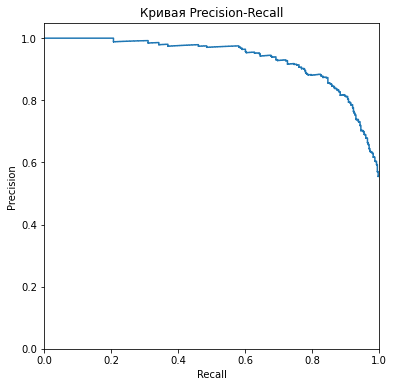

In [64]:
precision, recall, thresholds = precision_recall_curve(target_spacy_test, probabilities_one)
plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show()

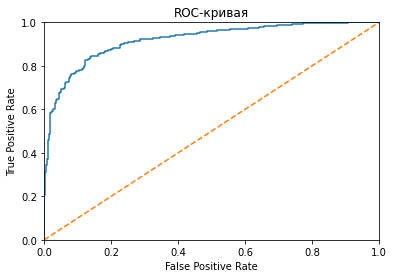

In [65]:
fpr, tpr, thresholds = roc_curve(target_spacy_test, probabilities_one) 
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [66]:
auc_roc = roc_auc_score(target_spacy_test, probabilities_one) 
print('Оценка в численном виде:', auc_roc)

Оценка в численном виде: 0.9189256130115311


### Примечания:
1. А до балансировки классов (с class_weight='balanced') было: 0.8056120965396918
2. А без стратификации было чуть больше

In [67]:
print('Воочию посмотрим как совпадают с истиной результаты предсказаний:')
tst = pd.DataFrame()
tst['txt'] = spacy_text_test
tst['toxic'] = np.array(target_spacy_test)
tst['pred'] = pred_spacy
display(tst.head(10))
print('А теперь только токсичные:')
display(tst.query('toxic==1').head())

Воочию посмотрим как совпадают с истиной результаты предсказаний:


,txt,toxic,pred
2521,harass and threaten people,1,1
2750,yeah do you spit or swallow,1,1
2225,that be ok Latvian be not the most usual langu...,0,0
1699,many of these be principale,0,0
2624,it be my religious view that she will burn in ...,1,1
1874,ps also guy I know we be lazy as fuck but come...,1,1
1226,nope I be afraid it be up to you today Libsey ...,1,0
2355,Bishonen so be you his lackey or just a sycoph...,1,1
93,a beating hello Shovon I see you 've take quit...,1,1
398,the problem be not your use of mixed spelling ...,1,0


А теперь только токсичные:


,txt,toxic,pred
2521,harass and threaten people,1,1
2750,yeah do you spit or swallow,1,1
2624,it be my religious view that she will burn in ...,1,1
1874,ps also guy I know we be lazy as fuck but come...,1,1
1226,nope I be afraid it be up to you today Libsey ...,1,0


### Выводы:
1. Осталась довольно большая доля ложно-отрицательных (FN) предсказаний. Часть токсичных комментариев не будет распознана.

In [77]:
sh = tst.shape[0]
print('Несовпадений', tst.query('toxic!=pred')['txt'].count(), 'из', sh)
fn = tst.query('toxic==1 and pred==0')['txt'].count()
print(f'Из них ложно-отрицательных (FN): {fn} ({np.round(100*fn/sh, 2)}%)')
fp = tst.query('toxic==0 and pred==1')['txt'].count()      
print(f'А ложно-положительных (FP): {fp} ({np.round(100*fp/sh, 2)}%)')

Несовпадений 114 из 764
Из них ложно-отрицательных (FN): 64 (8.38%)
А ложно-положительных (FP): 50 (6.54%)


### Теперь сделаем обзор по всем остальным вариантам представления текста

In [78]:
%%time

params = {'max_iter': [50, 100, 200],
          'penalty': ['none', 'l2', 'l1', 'elasticnet'],
          'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          'class_weight': [None, 'balanced'], 
          'C': [1, 10]}

lr = LogisticRegression(multi_class='auto', random_state=RS)
lr_model = GridSearchCV(lr, params, scoring='f1', cv=5)
lr_model.fit(features_spacy_train, target_spacy_train)

print("Лучшие параметры для модели LogisticRegression определенные GridSearchCV:", lr_model.best_params_)

Лучшие параметры для модели LogisticRegression определенные GridSearchCV: {'C': 1, 'class_weight': 'balanced', 'max_iter': 50, 'penalty': 'none', 'solver': 'lbfgs'}
Wall time: 1min 46s


In [79]:
%time

# пройдемся по всем типам текстов

text_type = ['clear', 'nltk', 'spacy']
res = []

for iii in range(len(text_type)):
    exam_clmn = '{}_text'.format(text_type[iii])
    print('Исследуем модель LogisticRegression на значениях столбца:', exam_clmn)
    exam_text = df_comm[exam_clmn].values.astype('U')
    target = df_comm['toxic']

    text_train, text_test, target_train, target_test = train_test_split(exam_text, target, test_size=TS, random_state=RS)

    features_train = count_tf_idf.fit_transform(text_train) 
    features_test = count_tf_idf.transform(text_test) 
    
#    model_exam = LogisticRegression(multi_class='auto', solver='saga', penalty='l2', max_iter=50, class_weight=None, random_state=RS, C=10) #т.к. классы несбалансированы
    model_exam = LogisticRegression(multi_class='auto', solver='lbfgs', penalty='none', max_iter=50, class_weight='balanced', random_state=RS, C=1)
    model_exam.fit(features_train, target_train)
    print('-- модель обучена')
    
    pred = model_exam.predict(features_test)
    print('-- есть предсказания')
    
    acc = np.round(accuracy_score(target_test, pred), 4)
    f1 = np.round(f1_score(target_test, pred), 4)
    print('-- accuracy_score:', acc)
    print('-- f1_score:', f1)
    res.append({'Тип текста': text_type[iii], 
                'accuracy_score': acc,
                'f1_score': f1}) 
    print('')

Wall time: 0 ns
Исследуем модель LogisticRegression на значениях столбца: clear_text
-- модель обучена
-- есть предсказания
-- accuracy_score: 0.839
-- f1_score: 0.8367

Исследуем модель LogisticRegression на значениях столбца: nltk_text
-- модель обучена
-- есть предсказания
-- accuracy_score: 0.8429
-- f1_score: 0.84

Исследуем модель LogisticRegression на значениях столбца: spacy_text
-- модель обучена
-- есть предсказания
-- accuracy_score: 0.8495
-- f1_score: 0.8473



In [80]:
res = pd.DataFrame(res)
display(res)

,Тип текста,accuracy_score,f1_score
0,clear,0.8390,0.8367
1,nltk,0.8429,0.8400
2,spacy,0.8495,0.8473


### Выводы:
1. <s>NLTK дал самый лучший результат.</s> Результат нестабилен - в этот раз лучший результат у spacy.
2. Лемматизация дает незначительный прирост качества модели по сравнению с очищенным текстом.

## Обучение
### Вариант с BERT

In [81]:
%time

print('Сначала наугад протестируем модель CatBoostClassifier (параметры отличаются от тех, что будут использованы далее):')

model_cb = CatBoostClassifier(bootstrap_type='MVS', depth=4, grow_policy='Depthwise', iterations=100, learning_rate=0.03, silent=True, random_seed=RS)
model_cb.fit(bert_features_train, bert_target_train)

Wall time: 0 ns
Сначала наугад протестируем модель CatBoostClassifier (параметры отличаются от тех, что будут использованы далее):


In [82]:
%time

pred_cb = model_cb.predict(bert_features_test)
print('cross_val_score:', cross_val_score(model_cb, bert_features_test, bert_target_test, cv=3))
print('accuracy_score:', accuracy_score(bert_target_test, pred_cb))
print('f1_score:', f1_score(bert_target_test, pred_cb))
print(model_cb.get_params(deep=False))

Wall time: 0 ns
cross_val_score: [0.848 0.852 0.856]
accuracy_score: 0.8506666666666667
f1_score: 0.8578680203045685
{'iterations': 100, 'learning_rate': 0.03, 'depth': 4, 'random_seed': 12345, 'silent': True, 'bootstrap_type': 'MVS', 'grow_policy': 'Depthwise'}


<div class="alert alert-info"> <b>Комментарий студента:</b> В предыдущий раз (с RuBERT) было:
<li> cross_val_score: [0.756 0.784 0.752]
<li> accuracy_score: 0.76
<li> f1_score: 0.7721518987341771
<div> <b>Результат значительно улучшился! F1=0.8578680203045685 (а без стратификации было 0.864321608040201)</b></div>
</div>    

In [83]:
%%time

params = {'max_depth': [4, 8, 10],
          'n_estimators': range(80, 240, 40),
         'min_samples_leaf': [1, 2]}

rf = RandomForestClassifier(class_weight=None, random_state=RS)
rf_model = GridSearchCV(rf, params, scoring='f1', cv=3)
rf_model.fit(bert_features_train, bert_target_train)

print("Лучшие параметры для модели RandomForestClassifier определенные GridSearchCV:", rf_model.best_params_)

Лучшие параметры для модели RandomForestClassifier определенные GridSearchCV: {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 80}
Wall time: 3min 4s


In [84]:
%%time

models = [LogisticRegression(multi_class='auto', solver='saga', penalty='l2', max_iter=50, class_weight=None, random_state=RS, C=10),          
          DecisionTreeClassifier(class_weight=None, max_depth=8, random_state=RS),
          RandomForestClassifier(class_weight=None, n_estimators=200, max_depth=10, min_samples_leaf=2, random_state=RS),
          CatBoostClassifier(bootstrap_type='MVS', depth=16, grow_policy='Lossguide', iterations=200, learning_rate=0.15, silent=True, random_seed=RS),
          LGBMClassifier(),
          XGBClassifier(),
          DummyClassifier(strategy='prior', random_state=RS)]

bert_results = []

for md in models:
    print(f'Идут вычисления по модели {md.__class__.__name__}:', md.get_params(deep=False))
    t1 = datetime.now() # Засекли время начала обучения
    md.fit(bert_features_train, bert_target_train)
    t2 = datetime.now() # Время окончания обучения и начала предсказания
    print('-- модель обучена')
    bert_pred = md.predict(bert_features_test)
    t3 = datetime.now() # Время окончания предсказания
    print('-- получены предсказания')
    t4 = t2 - t1 # Время обучения
    t5 = t3 - t2 # Время предсказания
    dt1 = str(np.round(t4.total_seconds(), 2))+'s' # Время обучения в секундах
    dt2 = str(np.round(t5.total_seconds(), 2))+'s' # Время предсказания в секундах
    
    md_acc = np.round(accuracy_score(bert_target_test, bert_pred), 4)
    md_f1 = np.round(f1_score(bert_target_test, bert_pred), 4)
    
    print('-- accuracy_score:', md_acc)
    print('-- f1_score:', md_f1)
    bert_results.append({'Модель': md.__class__.__name__, 
                         'accuracy_score': md_acc,
                         'f1_score': md_f1,
                         'Время_обучения': dt1,
                         'Время_предсказания': dt2,                    
                         'Гиперпараметры': md.get_params(deep=False),
                         'Модель_пригодна': md_f1>=CRIT_F1,
                         'pred': bert_pred}) 
    print('')
              
bert_results = pd.DataFrame(bert_results)
display(bert_results.drop('pred', axis=1))

Идут вычисления по модели LogisticRegression: {'C': 10, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 50, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 12345, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
-- модель обучена
-- получены предсказания
-- accuracy_score: 0.8867
-- f1_score: 0.8928

Идут вычисления по модели DecisionTreeClassifier: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 12345, 'splitter': 'best'}
-- модель обучена
-- получены предсказания
-- accuracy_score: 0.784
-- f1_score: 0.7955

Идут вычисления по модели RandomForestClassifier: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 1

,Модель,accuracy_score,f1_score,Время_обучения,Время_предсказания,Гиперпараметры,Модель_пригодна
0,LogisticRegression,0.8867,0.8928,1.81s,0.01s,"{'C': 10, 'class_weight': None, 'dual': False,...",True
1,DecisionTreeClassifier,0.7840,0.7955,1.35s,0.0s,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",True
2,RandomForestClassifier,0.8453,0.8520,6.78s,0.05s,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",True
3,CatBoostClassifier,0.8627,0.8688,74.22s,0.02s,"{'iterations': 200, 'learning_rate': 0.15, 'de...",True
4,LGBMClassifier,0.8560,0.8605,5.03s,0.0s,"{'boosting_type': 'gbdt', 'class_weight': None...",True
5,XGBClassifier,0.8707,0.8752,8.82s,0.01s,"{'objective': 'binary:logistic', 'use_label_en...",True
6,DummyClassifier,0.5320,0.6945,0.0s,0.0s,"{'constant': None, 'random_state': 12345, 'str...",False


Wall time: 1min 38s


In [85]:
bert_best_mod = bert_results.sort_values(by = 'f1_score', ascending = False).reset_index(drop=True).head(1)
print('Лучшая модель (при работе с BERT):', bert_best_mod.loc[0, 'Модель'])

Лучшая модель (при работе с BERT): LogisticRegression


### Вариант без BERT (на данных NLTK+TF-IDF)

In [86]:
%time

nltk_text = df_comm['nltk_text'].values.astype('U')
nltk_target = df_comm['toxic']

nltk_text_train, nltk_text_test, nltk_target_train, nltk_target_test = train_test_split(nltk_text, nltk_target, test_size=TS, random_state=RS)

count_tf_idf = TfidfVectorizer(stop_words=stopwords) 
nltk_features_train = count_tf_idf.fit_transform(nltk_text_train) 
nltk_features_test = count_tf_idf.transform(nltk_text_test) 

Wall time: 0 ns


In [87]:
%%time

models = [LogisticRegression(multi_class='auto', solver='saga', penalty='l2', max_iter=50, class_weight=None, random_state=RS, C=10),          
          DecisionTreeClassifier(class_weight=None, max_depth=8, random_state=RS),
          RandomForestClassifier(class_weight=None, n_estimators=200, max_depth=10, min_samples_leaf=2, random_state=RS),
          CatBoostClassifier(bootstrap_type='MVS', depth=16, grow_policy='Lossguide', iterations=200, learning_rate=0.15, silent=True, random_seed=RS),
          LGBMClassifier(),
          XGBClassifier(),
          DummyClassifier(strategy='prior', random_state=RS)]

tf_idf_results = []

for md in models:
    print(f'Идут вычисления по модели {md.__class__.__name__}:', md.get_params(deep=False))
    t1 = datetime.now() # Засекли время начала обучения
    md.fit(nltk_features_train, nltk_target_train)
    t2 = datetime.now() # Время окончания обучения и начала предсказания
    print('-- модель обучена')
    nltk_pred = md.predict(nltk_features_test)
    t3 = datetime.now() # Время окончания предсказания
    print('-- получены предсказания')
    t4 = t2 - t1 # Время обучения
    t5 = t3 - t2 # Время предсказания
    dt1 = str(np.round(t4.total_seconds(), 2))+'s' # Время обучения в секундах
    dt2 = str(np.round(t5.total_seconds(), 2))+'s' # Время предсказания в секундах
    
    md_acc = np.round(accuracy_score(nltk_target_test, nltk_pred), 4)
    md_f1 = np.round(f1_score(nltk_target_test, nltk_pred), 4)
    
    print('-- accuracy_score:', md_acc)
    print('-- f1_score:', md_f1)
    tf_idf_results.append({'Модель': md.__class__.__name__, 
                           'accuracy_score': md_acc,
                           'f1_score': md_f1,
                           'Время_обучения': dt1,
                           'Время_предсказания': dt2,                    
                           'Гиперпараметры': md.get_params(deep=False),
                           'Модель_пригодна': md_f1>=CRIT_F1,
                           'pred': nltk_pred}) 
    print('')
              
tf_idf_results = pd.DataFrame(tf_idf_results)
display(tf_idf_results.drop('pred', axis=1))

Идут вычисления по модели LogisticRegression: {'C': 10, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 50, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 12345, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
-- модель обучена
-- получены предсказания
-- accuracy_score: 0.8416
-- f1_score: 0.8389

Идут вычисления по модели DecisionTreeClassifier: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 12345, 'splitter': 'best'}
-- модель обучена
-- получены предсказания
-- accuracy_score: 0.6479
-- f1_score: 0.7111

Идут вычисления по модели RandomForestClassifier: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 

,Модель,accuracy_score,f1_score,Время_обучения,Время_предсказания,Гиперпараметры,Модель_пригодна
0,LogisticRegression,0.8416,0.8389,0.07s,0.0s,"{'C': 10, 'class_weight': None, 'dual': False,...",True
1,DecisionTreeClassifier,0.6479,0.7111,0.05s,0.0s,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",False
2,RandomForestClassifier,0.6832,0.7436,0.45s,0.05s,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",False
3,CatBoostClassifier,0.8115,0.7972,48.45s,0.03s,"{'iterations': 200, 'learning_rate': 0.15, 'de...",True
4,LGBMClassifier,0.7945,0.7942,0.26s,0.0s,"{'boosting_type': 'gbdt', 'class_weight': None...",True
5,XGBClassifier,0.8063,0.8068,0.56s,0.0s,"{'objective': 'binary:logistic', 'use_label_en...",True
6,DummyClassifier,0.4921,0.6596,0.0s,0.0s,"{'constant': None, 'random_state': 12345, 'str...",False


Wall time: 50 s


In [88]:
tf_idf_best_mod = tf_idf_results.sort_values(by = 'f1_score', ascending = False).reset_index(drop=True).head(1)
print('Лучшая модель (при работе с TF-IDF):', tf_idf_best_mod.loc[0, 'Модель'])

Лучшая модель (при работе с TF-IDF): LogisticRegression


In [89]:
print('Сравним результаты BERT и TF-IDF:')
delta = tf_idf_results.drop(['pred', 'Модель_пригодна', 'Гиперпараметры', 'Время_предсказания', 'Время_обучения', 'accuracy_score'], axis=1)
delta = delta.rename(columns={"f1_score": "f1_score_NLTK_TF_IDF"})
delta['f1_score_BERT'] = bert_results['f1_score']
display(delta)

Сравним результаты BERT и TF-IDF:


,Модель,f1_score_NLTK_TF_IDF,f1_score_BERT
0,LogisticRegression,0.8389,0.8928
1,DecisionTreeClassifier,0.7111,0.7955
2,RandomForestClassifier,0.7436,0.8520
3,CatBoostClassifier,0.7972,0.8688
4,LGBMClassifier,0.7942,0.8605
5,XGBClassifier,0.8068,0.8752
6,DummyClassifier,0.6596,0.6945


## Выводы
1. Балансировка классов оказала решающее действие на качество модели - метрика f1 подросла примерно в 2 раза.
2. <s>При заданных параметрах метод TF-IDF дает признаки для предсказания немного лучше чем в результате работы BERT. Возможно, дело в том, что для BERT используется ограничение длинны MXL=50.</s>После применения DistilBert метрика F1 стала чуть лучше (0.88 против 0.85) чем для метода TF-IDF, но скорость работы последнего выше.
3. <s>Модель CatBoostClassifier на обоих типах признаков дала примерно одинаковые значения</s>Модель CatBoostClassifier дала лучшее значение на данных подготвленных BERT (F1=0.8814), а модель LogisticRegression на признаках подгтовленных spacy+TF-IDF дала самый лучший результат (F1=0.8556 на данных подготовленных spacy и 0.8367 на данных подгоовленных NLTK).
4. Стратификация оказывает странный эффект - где-то она немного ухудшила качество, где-то улучшила. Думаю, что это все в пределах погрешности выборки.